In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [3]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
    pieces.append(signal[end:])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant',constant_values=piece[-1]))
    pieces_padded = np.array(pieces_padded)

    return pieces_padded

In [4]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    return [dis12/dis21, A0/A1]

In [ ]:
def use_kf(pieces):
    my_filter = KalmanFilter(dim_x=2, dim_z=1)

    # 滤波器状态估计
    my_filter.x = np.zeros((2, 1))     # initial state (location and velocity)
    dt = 0.01
    my_filter.F = np.array([[1, dt], [0, 1]])  # state transition matrix

    my_filter.H = np.array([[1.,0.]])    # Measurement function
    # my_filter.P *= 1000.                 # covariance matrix
    my_filter.P = np.zeros((2, 2))         # covariance matrix


    my_filter.R = 0.8                      # state uncertainty
    my_filter.Q = np.array([[0.04, 0], [0, 1]]) # process uncertainty

    # then, how to implement the filter?




In [10]:
def KalmanFilter(pieces, std=0.8):
    dt = 0.01
    t = np.linspace(0, 10, 1000, endpoint=False)

    X = np.zeros((2, 1)) # 2 * 1
    P = np.zeros((2, 2)) # 2 * 2
    X_arr = np.zeros((len(pieces[-1]), 2))

    Q = np.array([[0.04, 0], [0, 1]])
    F = np.array([[1, dt], [0, 1]])

    H = np.array([1,0])

    sig_var = np.ones(pieces[-1].shape) * std
    # print(sig_var.shape)
    # def init_kalman():
    def prediction(X, P, Q, F):
        # print(f'pre:{X.shape}')
        # print(f'F:{F.shape}')
        # print(f'X:{X.shape}')
        X = F @ X
        # print(f'pre:{X.shape}')

        P = F @ P @ F.T + Q
        return X, P

    def update(X, P, y, R, H):
        # Inn 1, S 1, K (2, 1)
        Inn = y - H @ X
        # print(f'Inn:{Inn.shape}')
        # print(f'H:{H.shape}, P:{P.shape}, R:{R.shape}')
        # print(R)
        S = H @ P @ H.T + R
        # print(f'S:{S.shape}')
        K = P @ H.T / S
        # print(f'K:{K.shape}')

        # X(2, 1), P (2, 2)
        X = X + K @ Inn
        P = P - K @ H @ P
        return X, P

    for i in range(len(pieces[-1])):
        if i == 0:
            # X, P = init_kalman(X, pieces[0, 0])
            X[0, 0] = pieces[0, 0]
            X[1, 0] = 0
            P = np.array([[100, 0], [0, 300]])
        else:
            # X(2, 1), P(2, 2), Q(2, 2) , F(2, 2)
            X, P = prediction(X, P, Q, F)
            for piece in pieces:
                # H(1, 2), X(2, 1), P(2, 2), y R 1
                X, P = update(X, P, piece[i].reshape(1, 1), sig_var[i:i+1].reshape(1, 1), H.reshape(1, 2))
                # print(X.shape)

        # print(X.shape)
        # print(X_arr[i, :].shape)
        X_arr[i, :] = X.T
        # print(X_arr)
    # print(X_arr.shape)
    # plt.figure(figsize=(10, 1.5))
    # plt.plot(X_arr[:, 0])

    # plt.figure()
    # for piece in pieces:
    #     plt.plot(piece, alpha=0.2)
    # plt.plot(pieces.mean(0), color='g')
    # plt.plot(X_arr[:, 0], color='r')
    return X_arr[:, 0]


In [34]:
from tqdm import tqdm
if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    def extract_features_KF(signals, labels, alpha, h, d):
        KF_featuers = []
        for cnt, signal in tqdm(enumerate(signals)):
            hr = labels[cnt, 2]
            large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
            pieces = segmentation(signal, large_peaks)
            template_kf = KalmanFilter(pieces, 0.8)
            features = get_features(template_kf, h, d)
            KF_featuers.append(features)
            # plt.plot(template_kf)
            # plt.show()
            # if cnt > echo:
            #     break
        return np.array(KF_featuers)

    # echo1, echo2 = 2000, 1000
    KF_features_train = extract_features_KF(signals_1_train, labels_1_train, 1, 0.1, 0.15)
    KF_features_test = extract_features_KF(signals_1_test, labels_1_test, 1.2, 0.12, 0.12)

# h d 0.1, 0.15
# h d 0.12, 0.12

(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


4718it [02:06, 37.15it/s]
2822it [01:18, 35.86it/s]


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()


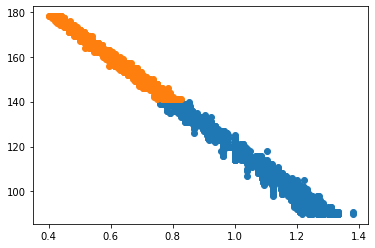

1.3733441313274939


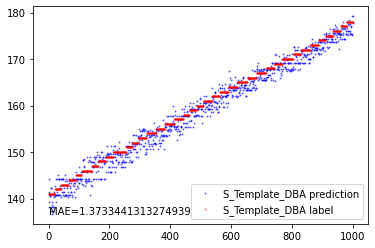

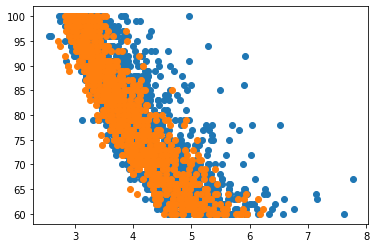

4.6083232954675575


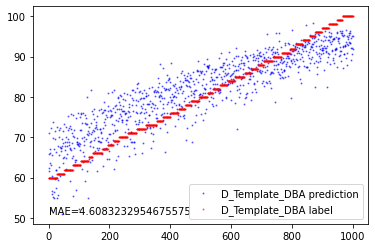

In [35]:
from sklearn.linear_model import LinearRegression as LR
# from Code.Tutorial.utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(KF_features_train[:echo1+2, 0],KF_features_test[:echo2+2, 0],labels_0_train[:echo1+2, 4],labels_0_test[:echo2+2, 4],'S_Template_DBA')
plot_plot(KF_features_train[:echo1+2, 1],KF_features_test[:echo2+2, 1],labels_0_train[:echo1+2, 5],labels_0_test[:echo2+2, 5],'D_Template_DBA')

In [ ]:
# 0.75
# 1.36 4.95

# 0.8
# 1.45, 4.82
# 1.37, 4.95

# 0.85

# 0.9
# 1.43, 4.96

# 0.95
# 1.40, 4.97

In [23]:
template_features_train[:, 0].shape,template_features_test[:, 0].shape,labels_0_train[:11, 4].shape,labels_0_test[:11, 4].shape

((12,), (12,), (11,), (11,))